# Integrate NDVI and MapBiomas data
This notebook combines NDVI anomaly rasters with MapBiomas LULC and irrigation rasters to create time series and maps that compare the heterogeneous incidence and extent of NDVI anomalies by land use class and irrigation systems.

In [5]:
#First, create agriculture, forest, and irrigation masks
#import libraries
import os
import rasterio
import numpy as np
import pandas as pd
from rasterio.warp import reproject, Resampling
#directories
ndvi_anom_dir = "maranhao_ndvi_anomaly_rasters"
mapb_dir      = "mapbiomas"
out_dir       = "maranhao_ndvi_lulc_maps"
os.makedirs(out_dir, exist_ok=True)
years = range(2000, 2025)
#Specify agriculture-related and forest-related LULC codes according to MapBiomas
AG_CODES = [18, 19, 20, 35, 36, 39, 40, 41, 46, 47, 48]
FOREST_CODES = [1, 3, 6, 9]

#Function to match MapBiomas data with NDVI data
def resample_to_match(src_path, match_ds, resampling):
    with rasterio.open(src_path) as src:
        dst = np.zeros(
            (match_ds.height, match_ds.width),
            dtype=np.float32
        )
        reproject(
            source=src.read(1),
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=match_ds.transform,
            dst_crs=match_ds.crs,
            resampling=resampling
        )
    return dst

#Main processing loop
for year in years:
    print(f"Processing {year}...")
    ndvi_path = os.path.join(
        ndvi_anom_dir, f"NDVI_rainy_anomaly_{year}.tif"
    )

    with rasterio.open(ndvi_path) as ndvi_ds:
        ndvi_anom = ndvi_ds.read(1).astype("float32")
        profile   = ndvi_ds.profile.copy()
        #Resample LULC data
        lulc = resample_to_match(
            os.path.join(mapb_dir, f"mapbiomas_lulc_{year}_maranhao_250m.tif"),
            ndvi_ds,
            Resampling.nearest
        )
        #Resample irrigation data
        irrigation = resample_to_match(
            os.path.join(mapb_dir, f"mapbiomas_irrigation_{year}_maranhao_250m.tif"),
            ndvi_ds,
            Resampling.nearest
        )
    #Define and apply masks
    cropland_mask  = np.isin(lulc, AG_CODES)
    forest_mask    = np.isin(lulc, FOREST_CODES)
    irrigated_mask = cropland_mask & (irrigation > 0)
    rainfed_mask   = cropland_mask & (irrigation == 0)
    irrigated_anom = np.where(irrigated_mask, ndvi_anom, np.nan)
    rainfed_anom   = np.where(rainfed_mask,   ndvi_anom, np.nan)
    forest_anom    = np.where(forest_mask,    ndvi_anom, np.nan)

    profile.update(
        dtype="float32",
        count=1,
        nodata=np.nan,
        compress="lzw"
    )
    #save files
    forest_out = os.path.join(
        out_dir, f"NDVI_rainy_anomaly_forest_{year}.tif"
    )
    irrig_out = os.path.join(
        out_dir, f"NDVI_rainy_anomaly_irrigated_{year}.tif"
    )
    rainf_out = os.path.join(
        out_dir, f"NDVI_rainy_anomaly_rainfed_{year}.tif"
    )
    with rasterio.open(forest_out, "w", **profile) as dst:
        dst.write(forest_anom.astype("float32"), 1)
        
    with rasterio.open(irrig_out, "w", **profile) as dst:
        dst.write(irrigated_anom.astype("float32"), 1)

    with rasterio.open(rainf_out, "w", **profile) as dst:
        dst.write(rainfed_anom.astype("float32"), 1)

    print(f"Saved anomaly rasters for {year}.")


Processing 2000...
Saved anomaly rasters for 2000.
Processing 2001...
Saved anomaly rasters for 2001.
Processing 2002...
Saved anomaly rasters for 2002.
Processing 2003...
Saved anomaly rasters for 2003.
Processing 2004...
Saved anomaly rasters for 2004.
Processing 2005...
Saved anomaly rasters for 2005.
Processing 2006...
Saved anomaly rasters for 2006.
Processing 2007...
Saved anomaly rasters for 2007.
Processing 2008...
Saved anomaly rasters for 2008.
Processing 2009...
Saved anomaly rasters for 2009.
Processing 2010...
Saved anomaly rasters for 2010.
Processing 2011...
Saved anomaly rasters for 2011.
Processing 2012...
Saved anomaly rasters for 2012.
Processing 2013...
Saved anomaly rasters for 2013.
Processing 2014...
Saved anomaly rasters for 2014.
Processing 2015...
Saved anomaly rasters for 2015.
Processing 2016...
Saved anomaly rasters for 2016.
Processing 2017...
Saved anomaly rasters for 2017.
Processing 2018...
Saved anomaly rasters for 2018.
Processing 2019...
Saved anomal

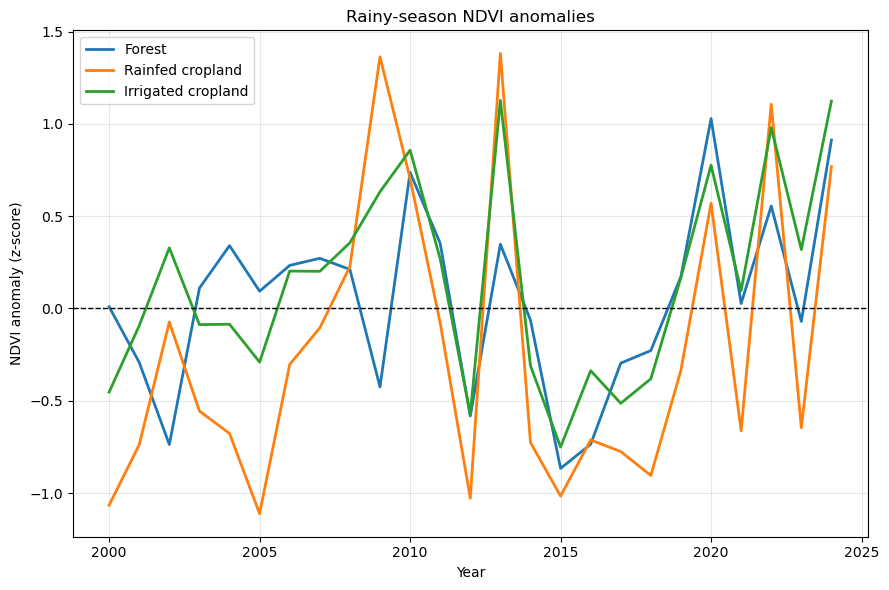

In [7]:
#Create time series of NDVI anomalies by LULC and irrigation
#import libraries
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
#directories
ndvi_dir = "maranhao_ndvi_anomaly_rasters"
mapb_dir      = "mapbiomas"

years = range(2000, 2025)
#LULC classes
AG_CODES = [18, 19, 20, 35, 36, 39, 40, 41, 46, 47, 48]
FOREST_CODES = [1, 3, 6, 9]
#resample MapBiomas
def resample_to_match(src_path, match_ds, resampling):
    with rasterio.open(src_path) as src:
        dst = np.zeros(
            (match_ds.height, match_ds.width),
            dtype=np.float32
        )

        reproject(
            source=src.read(1),
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=match_ds.transform,
            dst_crs=match_ds.crs,
            resampling=resampling
        )
    return dst

records = []
#Processing loop
for year in years:
    ndvi_path = os.path.join(
        ndvi_dir, f"NDVI_rainy_anomaly_{year}.tif"
    )

    with rasterio.open(ndvi_path) as ndvi_ds:
        ndvi = ndvi_ds.read(1).astype("float32")
        #Resample LULC
        lulc = resample_to_match(
            os.path.join(mapb_dir, f"mapbiomas_lulc_{year}_maranhao_250m.tif"),
            ndvi_ds,
            Resampling.nearest
        )
        #Resample Irrigation
        irrigation = resample_to_match(
            os.path.join(mapb_dir, f"mapbiomas_irrigation_{year}_maranhao_250m.tif"),
            ndvi_ds,
            Resampling.nearest
        )
    #Create and apply masks
    forest_mask   = np.isin(lulc, FOREST_CODES)
    cropland_mask = np.isin(lulc, AG_CODES)
    rainfed_mask  = cropland_mask & (irrigation == 0)
    irrig_mask    = cropland_mask & (irrigation > 0)
    #Append data
    records.append({
        "year": year,
        "forest":   np.nanmean(ndvi[forest_mask]),
        "rainfed":  np.nanmean(ndvi[rainfed_mask]),
        "irrigated":np.nanmean(ndvi[irrig_mask])
    })
#Save to dataframe
df = pd.DataFrame(records).sort_values("year")
df.head()
#Plot time series
plt.figure(figsize=(9,6))
plt.plot(df["year"], df["forest"], label="Forest", linewidth=2)
plt.plot(df["year"], df["rainfed"], label="Rainfed cropland", linewidth=2)
plt.plot(df["year"], df["irrigated"], label="Irrigated cropland", linewidth=2)

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Year")
plt.ylabel("NDVI anomaly (z-score)")
plt.title("Rainy-season NDVI anomalies")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


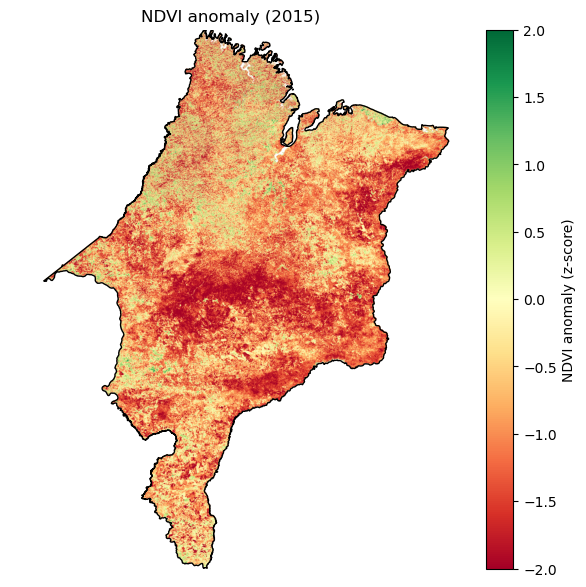

In [2]:
#Create maps of NDVI anomalies for individual years (exploratory analysis)
#import libraries
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
path = "maranhao_ndvi_anomaly_rasters/NDVI_rainy_anomaly_2015.tif"
maranhao = gpd.read_file("maranhao_boundary/maranhao_boundary.shp") #shapefile
with rasterio.open(path) as ds:
    arr = ds.read(1)
    extent = [
        ds.bounds.left,
        ds.bounds.right,
        ds.bounds.bottom,
        ds.bounds.top
    ]
#Plot map
cmap = plt.cm.RdYlGn.copy()
cmap.set_bad("white")
plt.figure(figsize=(9,7))
plt.imshow(
    arr,
    cmap=cmap,
    vmin=-2,
    vmax=2,
    extent=extent,
    origin="upper"
)
#Add Maranhao boundary
maranhao.boundary.plot(
    ax=plt.gca(),
    edgecolor="black",
    linewidth=1
)
plt.title("NDVI anomaly (2015)")
plt.axis("off")
plt.colorbar(label="NDVI anomaly (z-score)")
plt.show()

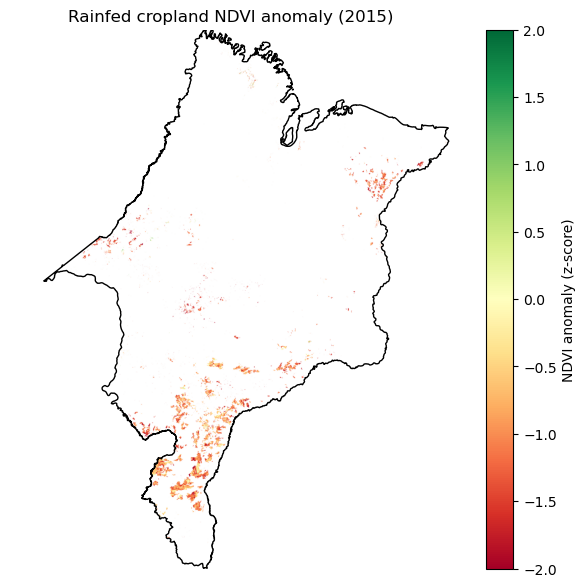

In [27]:
#Same thing, but for rainfed agriculture only
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
path = "maranhao_ndvi_lulc_maps/NDVI_rainy_anomaly_rainfed_2015.tif"
maranhao = gpd.read_file("maranhao_boundary/maranhao_boundary.shp")
with rasterio.open(path) as ds:
    arr = ds.read(1)
    extent = [
        ds.bounds.left,
        ds.bounds.right,
        ds.bounds.bottom,
        ds.bounds.top
    ]

cmap = plt.cm.RdYlGn.copy()
cmap.set_bad("white")
plt.figure(figsize=(9,7))
plt.imshow(
    arr,
    cmap=cmap,
    vmin=-2,
    vmax=2,
    extent=extent,
    origin="upper"
)

maranhao.boundary.plot(
    ax=plt.gca(),
    edgecolor="black",
    linewidth=1
)

plt.title("Rainfed cropland NDVI anomaly (2015)")
plt.axis("off")
plt.colorbar(label="NDVI anomaly (z-score)")
plt.show()



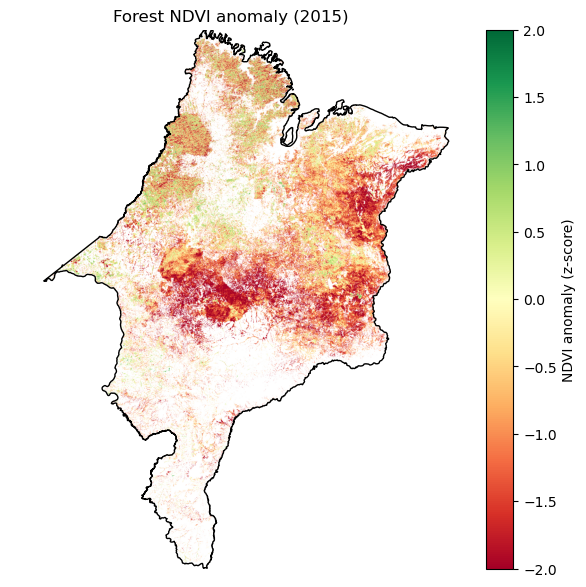

In [28]:
#Same thing, but for forest area only
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
path = "maranhao_ndvi_lulc_maps/NDVI_rainy_anomaly_forest_2015.tif"
maranhao = gpd.read_file("maranhao_boundary/maranhao_boundary.shp")
with rasterio.open(path) as ds:
    arr = ds.read(1)
    extent = [
        ds.bounds.left,
        ds.bounds.right,
        ds.bounds.bottom,
        ds.bounds.top
    ]

cmap = plt.cm.RdYlGn.copy()
cmap.set_bad("white")

plt.figure(figsize=(9,7))
plt.imshow(
    arr,
    cmap=cmap,
    vmin=-2,
    vmax=2,
    extent=extent,
    origin="upper"
)

maranhao.boundary.plot(
    ax=plt.gca(),
    edgecolor="black",
    linewidth=1
)

plt.title("Forest NDVI anomaly (2015)")
plt.axis("off")
plt.colorbar(label="NDVI anomaly (z-score)")
plt.show()


In [11]:
#Create animated gif of all maps 2000-2024, for whole state
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import imageio.v2 as imageio
#directories
ndvi_dir = "maranhao_ndvi_anomaly_rasters"
out_frames = "gif_frames"
out_gif    = "NDVI_rainy_anomaly_2000_2024.gif"
os.makedirs(out_frames, exist_ok=True)

years = range(2000, 2025)
maranhao = gpd.read_file(maranhao).to_crs("EPSG:4326")

cmap = plt.cm.RdYlGn.copy()
cmap.set_bad("white")
frame_paths = []
#Process each year, make and save map
for year in years:
    print(f"Rendering {year}")
    path = os.path.join(
        ndvi_dir, f"NDVI_rainy_anomaly_{year}.tif"
    )

    with rasterio.open(path) as ds:
        arr = ds.read(1)
        extent = [
            ds.bounds.left,
            ds.bounds.right,
            ds.bounds.bottom,
            ds.bounds.top
        ]
    fig, ax = plt.subplots(figsize=(9,7))

    im = ax.imshow(
        arr,
        cmap=cmap,
        vmin=-2,
        vmax=2,
        extent=extent,
        origin="upper"
    )

    maranhao.boundary.plot(
        ax=ax,
        edgecolor="black",
        linewidth=1
    )

    ax.set_title(f"Rainy-season NDVI anomaly ({year})")
    ax.axis("off")

    cbar = fig.colorbar(im, ax=ax, shrink=0.85)
    cbar.set_label("NDVI anomaly (z-score)")
    #Save each frame
    frame_path = os.path.join(out_frames, f"ndvi_{year}.png")
    plt.savefig(frame_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    frame_paths.append(frame_path)
#Write movie
with imageio.get_writer(out_gif, mode="I", duration=4, loop = 0) as writer:
    for frame in frame_paths:
        image = imageio.imread(frame)
        writer.append_data(image)

print(f"Saved GIF: {out_gif}")


Rendering 2000
Rendering 2001
Rendering 2002
Rendering 2003
Rendering 2004
Rendering 2005
Rendering 2006
Rendering 2007
Rendering 2008
Rendering 2009
Rendering 2010
Rendering 2011
Rendering 2012
Rendering 2013
Rendering 2014
Rendering 2015
Rendering 2016
Rendering 2017
Rendering 2018
Rendering 2019
Rendering 2020
Rendering 2021
Rendering 2022
Rendering 2023
Rendering 2024
Saved GIF: NDVI_rainy_anomaly_2000_2024_new.gif


In [2]:
#Same thing, but for rainfed agriculture only
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import imageio.v2 as imageio
#directories
ndvi_dir = "maranhao_ndvi_lulc_maps"
out_frames = "gif_frames"
out_gif    = "NDVI_rainy_anomaly_rainfed_2000_2024.gif"
os.makedirs(out_frames, exist_ok=True)

years = range(2000, 2025)
maranhao = gpd.read_file(maranhao).to_crs("EPSG:4326")

cmap = plt.cm.RdYlGn.copy()
cmap.set_bad("white")

frame_paths = []
for year in years:
    print(f"Rendering {year}")

    path = os.path.join(
        ndvi_dir, f"NDVI_rainy_anomaly_rainfed_{year}.tif"
    )
    with rasterio.open(path) as ds:
        arr = ds.read(1)
        extent = [
            ds.bounds.left,
            ds.bounds.right,
            ds.bounds.bottom,
            ds.bounds.top
        ]

    fig, ax = plt.subplots(figsize=(9,7))

    im = ax.imshow(
        arr,
        cmap=cmap,
        vmin=-2,
        vmax=2,
        extent=extent,
        origin="upper"
    )

    maranhao.boundary.plot(
        ax=ax,
        edgecolor="black",
        linewidth=1
    )

    ax.set_title(f"Rainfed cropland NDVI anomaly ({year})")
    ax.axis("off")

    cbar = fig.colorbar(im, ax=ax, shrink=0.85)
    cbar.set_label("NDVI anomaly (z-score)")

    frame_path = os.path.join(out_frames, f"ndvi_{year}.png")
    plt.savefig(frame_path, dpi=200, bbox_inches="tight")
    plt.close(fig)

    frame_paths.append(frame_path)

with imageio.get_writer(out_gif, mode="I", duration=4, loop= 0) as writer:
    for frame in frame_paths:
        image = imageio.imread(frame)
        writer.append_data(image)

print(f"Saved GIF: {out_gif}")

Rendering 2000
Rendering 2001
Rendering 2002
Rendering 2003
Rendering 2004
Rendering 2005
Rendering 2006
Rendering 2007
Rendering 2008
Rendering 2009
Rendering 2010
Rendering 2011
Rendering 2012
Rendering 2013
Rendering 2014
Rendering 2015
Rendering 2016
Rendering 2017
Rendering 2018
Rendering 2019
Rendering 2020
Rendering 2021
Rendering 2022
Rendering 2023
Rendering 2024
Saved GIF: NDVI_rainy_anomaly_rainfed_2000_2024_new.gif


In [4]:
#Same thing, but for forested areas only
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import imageio.v2 as imageio
#directories
ndvi_dir = "maranhao_ndvi_lulc_maps"
out_frames = "gif_frames"
out_gif    = "NDVI_rainy_anomaly_forest_2000_2024.gif"
os.makedirs(out_frames, exist_ok=True)

years = range(2000, 2025)
maranhao = gpd.read_file(maranhao).to_crs("EPSG:4326")

cmap = plt.cm.RdYlGn.copy()
cmap.set_bad("white")

frame_paths = []
for year in years:
    print(f"Rendering {year}")

    path = os.path.join(
        ndvi_dir, f"NDVI_rainy_anomaly_forest_{year}.tif"
    )
    with rasterio.open(path) as ds:
        arr = ds.read(1)
        extent = [
            ds.bounds.left,
            ds.bounds.right,
            ds.bounds.bottom,
            ds.bounds.top
        ]

    fig, ax = plt.subplots(figsize=(9,7))

    im = ax.imshow(
        arr,
        cmap=cmap,
        vmin=-2,
        vmax=2,
        extent=extent,
        origin="upper"
    )

    maranhao.boundary.plot(
        ax=ax,
        edgecolor="black",
        linewidth=1
    )

    ax.set_title(f"Forest NDVI anomaly ({year})")
    ax.axis("off")

    cbar = fig.colorbar(im, ax=ax, shrink=0.85)
    cbar.set_label("NDVI anomaly (z-score)")

    frame_path = os.path.join(out_frames, f"ndvi_{year}.png")
    plt.savefig(frame_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    frame_paths.append(frame_path)

with imageio.get_writer(out_gif, mode="I", duration=4, loop= 0) as writer:
    for frame in frame_paths:
        image = imageio.imread(frame)
        writer.append_data(image)

print(f"Saved GIF: {out_gif}")

Rendering 2000
Rendering 2001
Rendering 2002
Rendering 2003
Rendering 2004
Rendering 2005
Rendering 2006
Rendering 2007
Rendering 2008
Rendering 2009
Rendering 2010
Rendering 2011
Rendering 2012
Rendering 2013
Rendering 2014
Rendering 2015
Rendering 2016
Rendering 2017
Rendering 2018
Rendering 2019
Rendering 2020
Rendering 2021
Rendering 2022
Rendering 2023
Rendering 2024
Saved GIF: NDVI_rainy_anomaly_forest_2000_2024_new.gif


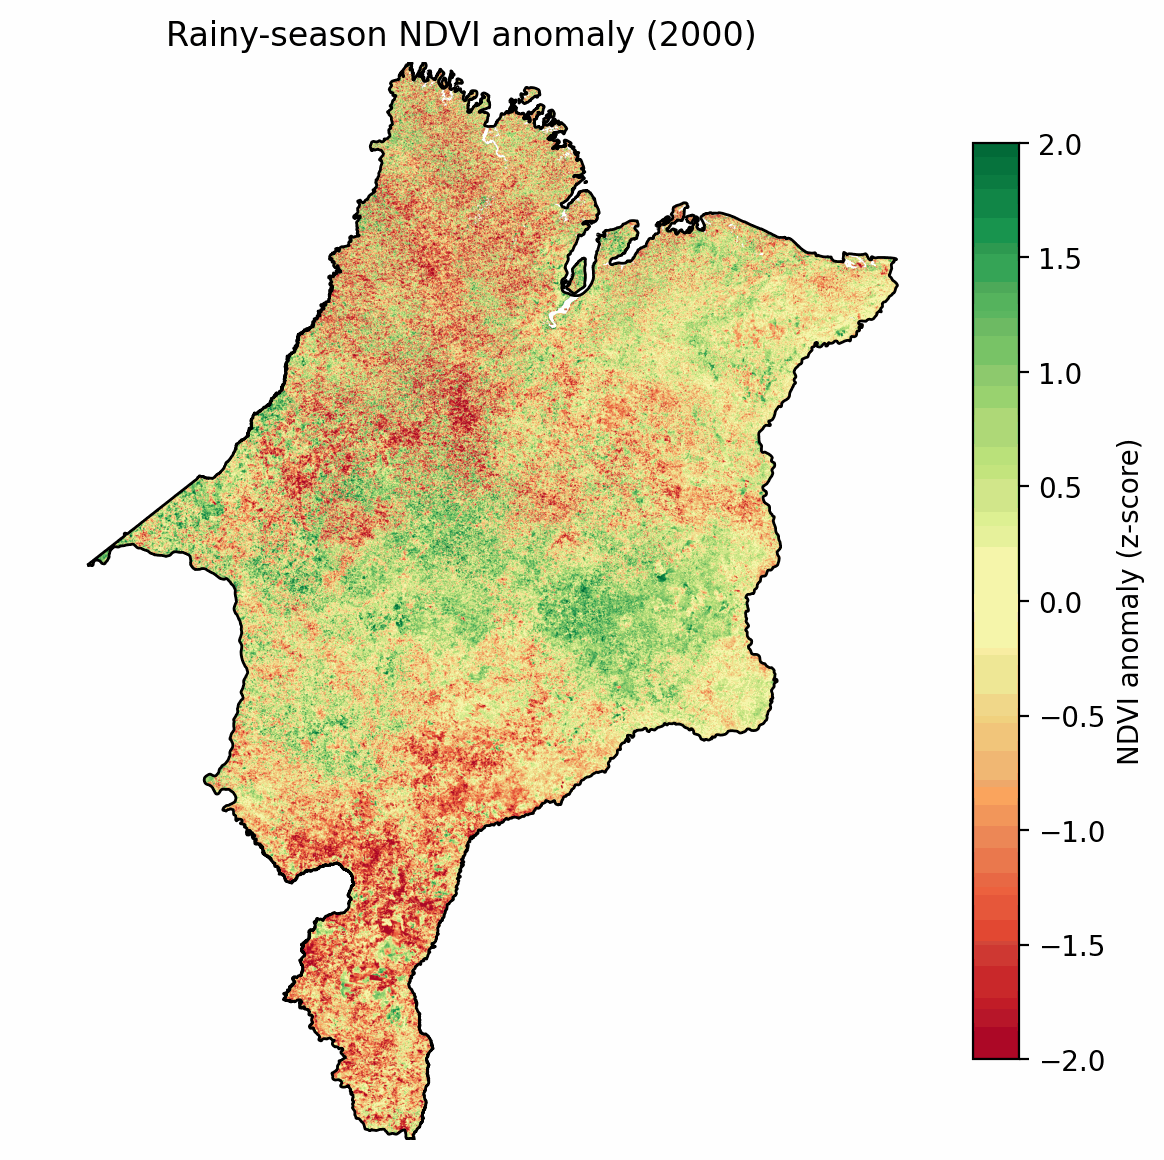

In [1]:
from IPython.display import Image, display
display(Image(filename="NDVI_rainy_anomaly_forest_2000_2024.gif"))